# $  Chapter-0: Pilot  $

In [1]:
%matplotlib inline
import pandas as pda
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import glob
import os
from pynbody import filt
import re
import struct
from pynbody import units
params = {"font.family":"serif","mathtext.fontset":"stix"}
matplotlib.rcParams.update(params)
from matplotlib.patches import Polygon
from itertools import cycle

In [2]:
filename = 'GLXsp4.00400'

In [3]:
dno  = filename.split('.')[-1]
s    = pynbody.load(filename)

params = glob.glob('*.param')[0]
with open(params) as f:
    for line in f:
        if "InitGasMass" in line:
             InitGasMass=float((line.split('=')[1]).split('#')[0])#,s['mass'].units


In [4]:
print('-------PREAMBLE-------')
s.physical_units()
print(s.families())
print(s.loadable_keys())
print(s.properties)
print(s.g)
print(s.gas.loadable_keys())
print(s.s)
print(s.star.loadable_keys())
print(s.d)
print(s.dm.loadable_keys())

print('------SETUP-DONE------')
#Put CoM in middle
#pynbody.analysis.angmom.faceon(s)
#Rotate if we want
s.rotate_y(180)
#Some useful filters:
sphere  = pynbody.filt.Sphere('20 kpc')
#bin stuff up radially:
p  = pynbody.analysis.profile.Profile(s,max='60 kpc',min='0.1 kpc',type='log',nbins=100)
pd = pynbody.analysis.profile.Profile(s.dm,max='60 kpc',min='0.1 kpc',type='log',nbins=100)
pg = pynbody.analysis.profile.Profile(s.gas,max='60 kpc',min='0.1 kpc',type='log',nbins=100)
ps = pynbody.analysis.profile.Profile(s.stars,max='60 kpc',min='0.1 kpc',type='log',nbins=100)

ymisc = 'n'
ymet  = 'n'
if len(s.gas.loadable_keys())<9:
  ymet='n'
  print('Cant do metals...')
    

-------PREAMBLE-------
[<Family gas>, <Family star>]
['vel', 'pos', 'eps', 'phi', 'mass']
{'time': Unit("4.09e-01 kpc s km**-1")}
<SimSnap "GLXsp4.00400::gas" len=3119104>
['vel', 'metals', 'pos', 'eps', 'phi', 'temp', 'rho', 'mass']
<SimSnap "GLXsp4.00400::star" len=880897>
['vel', 'metals', 'eps', 'phi', 'pos', 'mass', 'tform']
<SimSnap "GLXsp4.00400::dm" len=0>
['vel', 'eps', 'phi', 'pos', 'mass']
------SETUP-DONE------
Cant do metals...


In [5]:
#Plots of stellar densities (all stars on left, only "young" stars on right)
pretime    = pynbody.units.Unit('50. Myr')  #lookback time for SFR calc. default 50Myr

youngs = pynbody.filt.BandPass('age', '0 Gyr', '13 Gyr')
olds   = pynbody.filt.LowPass('age', '0 Gyr')   #negative ages are formed in future, and are IC stars
freshs = pynbody.filt.BandPass('age', '0 Gyr', pretime)
alls   = pynbody.filt.BandPass('age', '-100 Gyr','100 Gyr') #just a filter for all

print('no. of stars:',len(s.star[alls]['x']))
print('no. of IC/old stars:',len(s.star[olds]['x']))
print('no. of formed stars:',len(s.star[youngs]['x']))
print('no. of fresh stars: ',len(s.star[freshs]['x']))

no. of stars: 880897
no. of IC/old stars: 0
no. of formed stars: 880897
no. of fresh stars:  98807


# $  Chapter-1: The\;Initiation  $

In [6]:
#plotting gas or stars?
ptype = 'g'

# assign arrays according to above answer
if ptype == 'g':
    xa = s.g[sphere]['x'] 
    ya = s.g[sphere]['y']
    vxa = s.g[sphere]['vx'] 
    vya = s.g[sphere]['vy']
    rhos= s.g[sphere]['rho'].in_units('g cm^-3')/1.67e-24
    
    ptype2 = 'g'
if ptype == 's':
    pop = alls ; ptype2='s0all'
    pop = olds ; ptype2='s1old'
    pop = youngs ; ptype2='s2young'
    pop = freshs ; ptype2='s3fresh'

    xa = s.s[sphere][pop]['x']
    ya = s.s[sphere][pop]['y']
    vxa = s.s[sphere][pop]['vx'] 
    vya = s.s[sphere][pop]['vy']
    rhos= s.s[sphere][pop]['mass'].in_units('Msol')

In [7]:
#setting new rhos, xa, and ya
rhos_cut = np.mean(rhos) #new density

xa_cut = xa[rhos > rhos_cut] #new xa [kpc]
ya_cut = ya[rhos > rhos_cut] #new ya [kpc]

#setting new vxa and vya 
vxa_cut = vxa[rhos > rhos_cut] #new vxa [km/s]
vya_cut = vya[rhos > rhos_cut] #new vya [km/s]


# $  Chapter-2: The\;Purpose  $

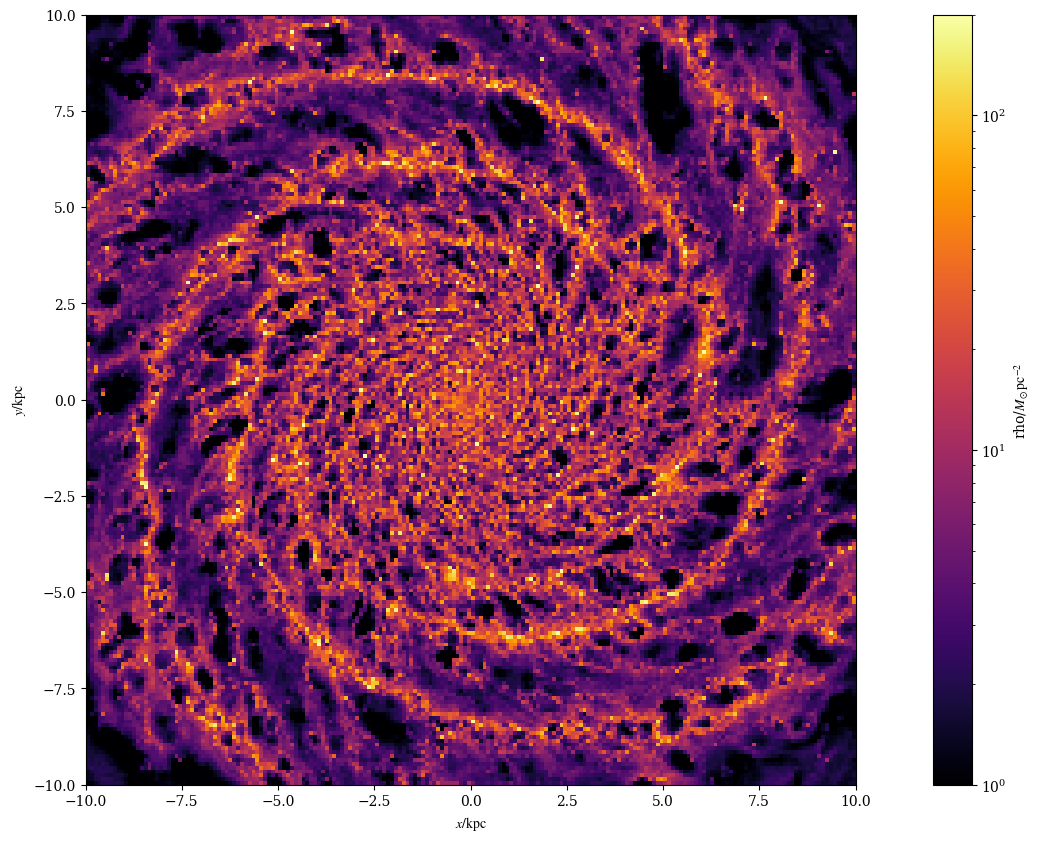

In [8]:
#plotting sample image
plt.figure(1, (20, 10))
axG = plt.subplot(111)
A3 = sph.image(s.gas, qty = 'rho', width = '20 kpc', cmap = 'inferno', vmin = 1, vmax = 200, units = 'Msol pc^-2', subplot = axG, show_cbar = True, resolution = 200)
plt.show()

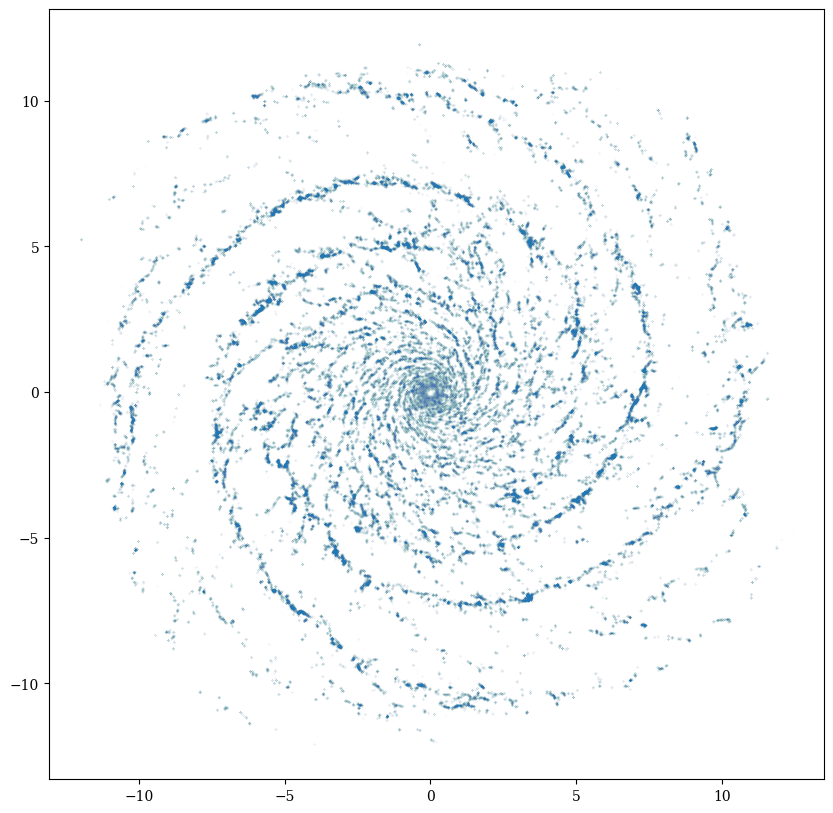

In [55]:
# Forshadowing Chapter 6
def what_if(rotating = False, degree=0):
    theta0 = np.arctan2(ya_cut, xa_cut)
    # It needs rotation angle added to it

    # Theta to degree
    theta0_deg = np.degrees(theta0)

    # Input rotation angle in degrees
    if rotating:
        rotation_angle_deg = degree
    else:
        rotation_angle_deg = 0

    # Convert rotation angle to radians
    rotation_angle_rad = np.radians(rotation_angle_deg)

    # Rotation matrix
    cos_theta = np.cos(rotation_angle_rad)
    sin_theta = np.sin(rotation_angle_rad)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])

    rotated_points = np.dot(rotation_matrix, np.array([xa_cut, ya_cut]))
    rotated_velocities = np.dot(rotation_matrix, np.array([vxa_cut, vya_cut]))

    #Setting up new xa, ya, vxa, and vya values 
    new_xa = rotated_points[0]
    new_ya = rotated_points[1]

    new_vxa = rotated_velocities[0]
    new_vya = rotated_velocities[1]

    plt.figure(8, (10, 10))
    plt.scatter(new_xa, new_ya, s = 0.01, alpha = 0.065)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.gca().set_aspect('equal', adjustable='datalim')
    return theta0, theta0_deg, new_xa, new_ya, new_vxa, new_vya, rotation_matrix
    
rotation_matrix = what_if(True, 45)


# $  Chapter-3: The\;Nexus\;Events   $

In [35]:
#{'region':[x1, y1, x2, y2, x3, y3, x4, y4]} <--point arrangements
point_list = [
    {'first_region':[-4.9, 2.7, 1.5, 2.7, 1.5, 5.7, -4.9, 5.7]},
    {'second_region':[-4.9, 5.7, 1.5, 5.7, 1.5, 8.1, -4.9, 8.1]},
    {'third_region':[]},
    {'fourth_region':[]}
]


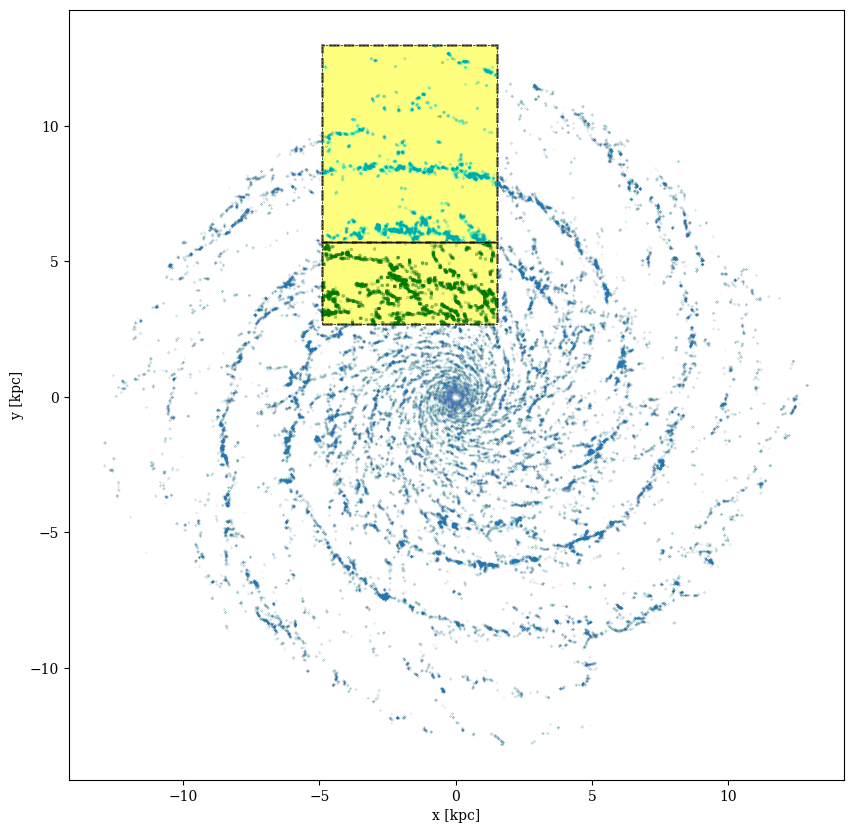

In [36]:
#Setting up the figures
plt.figure(1, (10, 10))

#Assigning new plots and creating new area
plt.scatter(xa_cut, ya_cut, s = 0.01, alpha = 0.065)
plt.xlabel('x [kpc]'); plt.ylabel('y [kpc]')

#Inserting linear equation
def get_line_eq(x0, x1, y0, y1):
    return y0 - y1, x1 - x0, x0 * y1 - x1 * y0

#Creating points
xa0, xa1, xa2, xa3, ya0, ya1, ya2, ya3 = [3.5, 6.0, 7.0, 5.0, -3.5, -3.5, -1.5, -1.5]     #Selecting points    
xb0, xb1, xb2, xb3, yb0, yb1, yb2, yb3 = [-4.8, -3.0, -3.0, -4.8, -1.0, -1.0, 1.0, 1.0]
xc0, xc1, xc2, xc3, yc0, yc1, yc2, yc3 = [2.3, 3.5, 2.5, 1.5, 2.0, 2.0, 4.0, 5.0]
xd0, xd1, xd2, xd3, yd0, yd1, yd2, yd3 = [-1.0, 1.0, 0, -1.5, -5.4, -6.0, -4.0, -3.8]
xe0, xe1, xe2, xe3, ye0, ye1, ye2, ye3 = [-4.9, 1.5, 1.5, -4.9, 2.7, 2.7, 5.7, 5.7]

xf0, xf1, xf2, xf3, yf0, yf1, yf2, yf3 = [-4.9, 1.5, 1.5, -4.9, 5.7, 5.7, 13, 13]


pnts0 = [[xa0, ya0], [xa1, ya1], [xa2, ya2], [xa3, ya3]]
pnts1 = [[xb0, yb0], [xb1, yb1], [xb2, yb2], [xb3, yb3]]
pnts2 = [[xc0, yc0], [xc1, yc1], [xc2, yc2], [xc3, yc3]]
pnts3 = [[xd0, yd0], [xd1, yd1], [xd2, yd2], [xd3, yd3]]
pnts4 = [[xe0, ye0], [xe1, ye1], [xe2, ye2], [xe3, ye3]]

pnts5 = [[xf0, yf0], [xf1, yf1], [xf2, yf2], [xf3, yf3]]
  

pnts0 = pnts0 + [pnts0[0]] # repeat first point to create a closed polygon
pnts0 = np.array(pnts0) # numpy arrays are easier to separate x and y coordinates
pnts1 = pnts1 + [pnts1[0]] # repeat first point to create a closed polygon
pnts1 = np.array(pnts1) # numpy arrays are easier to separate x and y coordinates
pnts2 = pnts2 + [pnts2[0]] # repeat first point to create a closed polygon
pnts2 = np.array(pnts2) # numpy arrays are easier to separate x and y coordinates
pnts3 = pnts3 + [pnts3[0]] # repeat first point to create a closed polygon
pnts3 = np.array(pnts3) # numpy arrays are easier to separate x and y coordinates
pnts4 = pnts4 + [pnts4[0]] # repeat first point to create a closed polygon
pnts4 = np.array(pnts4) # numpy arrays are easier to separate x and y coordinates
pnts5 = pnts5 + [pnts5[0]] # repeat first point to create a closed polygon
pnts5 = np.array(pnts5) # numpy arrays are easier to separate x and y coordinates


#plt.plot(pnts0[:, 0], pnts0[:, 1], 'k--', lw=0.5)
#plt.plot(pnts1[:, 0], pnts1[:, 1], 'k--', lw=0.5)
#plt.plot(pnts2[:, 0], pnts2[:, 1], 'k--', lw=0.5)
#plt.plot(pnts3[:, 0], pnts3[:, 1], 'k--', lw=0.5)
plt.plot(pnts4[:, 0], pnts4[:, 1], 'k--', lw=0.5)
plt.plot(pnts5[:, 0], pnts5[:, 1], 'k--', lw=0.5)

#Putting those points into our equation and filter what we want
equations0 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts0[:-1], pnts0[1:])]
equations1 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts1[:-1], pnts1[1:])]
equations2 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts2[:-1], pnts2[1:])]
equations3 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts3[:-1], pnts3[1:])]
equations4 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts4[:-1], pnts4[1:])]
equations5 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts5[:-1], pnts5[1:])]

filter0 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations0], axis = 0)
filter1 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations1], axis = 0)
filter2 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations2], axis = 0)
filter3 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations3], axis = 0)
filter4 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations4], axis = 0)
filter5 = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equations5], axis = 0)

#Filtering out from new xa, ya, vxa, and vya values
xa_cut_for_lv0 = xa_cut[filter0]
ya_cut_for_lv0 = ya_cut[filter0]

vxa_cut_for_lv0 = vxa_cut[filter0]
vya_cut_for_lv0 = vya_cut[filter0]

xa_cut_for_lv1 = xa_cut[filter1]
ya_cut_for_lv1 = ya_cut[filter1]

vxa_cut_for_lv1 = vxa_cut[filter1]
vya_cut_for_lv1 = vya_cut[filter1]

xa_cut_for_lv2 = xa_cut[filter2]
ya_cut_for_lv2 = ya_cut[filter2]

vxa_cut_for_lv2 = vxa_cut[filter2]
vya_cut_for_lv2 = vya_cut[filter2]

xa_cut_for_lv3 = xa_cut[filter3]
ya_cut_for_lv3 = ya_cut[filter3]

vxa_cut_for_lv3 = vxa_cut[filter3]
vya_cut_for_lv3 = vya_cut[filter3]

xa_cut_for_lv4 = xa_cut[filter4]
ya_cut_for_lv4 = ya_cut[filter4]

vxa_cut_for_lv4 = vxa_cut[filter4]
vya_cut_for_lv4 = vya_cut[filter4]

xa_cut_for_lv5 = xa_cut[filter5]
ya_cut_for_lv5 = ya_cut[filter5]

vxa_cut_for_lv5 = vxa_cut[filter5]
vya_cut_for_lv5 = vya_cut[filter5]


#selecting area and coloring yellow
#plt.scatter(xa_cut_for_lv0, ya_cut_for_lv0, s = .01, color = 'red', alpha = 0.08, lw = 2)
#plt.scatter(xa_cut_for_lv1, ya_cut_for_lv1, s = .01, color = 'purple', alpha = 0.08, lw = 2)
#plt.scatter(xa_cut_for_lv2, ya_cut_for_lv2, s = .01, color = 'cyan', alpha = 0.08, lw = 2)
#plt.scatter(xa_cut_for_lv3, ya_cut_for_lv3, s = .01, color = 'chocolate', alpha = 0.08, lw = 2)
plt.scatter(xa_cut_for_lv4, ya_cut_for_lv4, s = .01, color = 'green', alpha = 0.08, lw = 2)
plt.scatter(xa_cut_for_lv5, ya_cut_for_lv5, s = .01, color = 'cyan', alpha = 0.08, lw = 2)

#plt.fill(pnts0[:, 0], pnts0[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)
#plt.fill(pnts1[:, 0], pnts1[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)
#plt.fill(pnts2[:, 0], pnts2[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)
#plt.fill(pnts3[:, 0], pnts3[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)
plt.fill(pnts4[:, 0], pnts4[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)
plt.fill(pnts5[:, 0], pnts5[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)


In [11]:
"""#Inserting linear equation
def get_line_eq(x0, x1, y0, y1):
    return y0 - y1, x1 - x0, x0 * y1 - x1 * y0

#Creating points
point_list = []

while True:
    point_array_name = input("Enter a name for the array: ") #input an array's name
    
    if point_array_name == 'exit':
        break       #to close all the arrays
    
    new_point_array_name = []  #initializing an empty array

    #Input loop to add elements to the new array
    while True:
        new_points = input("Enter an element for the array: ") #input elements in an array
        if new_points == 'done':
            break   #to close an array
        new_point_array_name.append(float(new_points))
    
    dictionary_of_points_array = {point_array_name: new_point_array_name}  # Create a dictionary with the array and its name
    point_list.append(dictionary_of_points_array)  # Add the dictionary to the list
    
    
    print(point_list)"""
   

'#Inserting linear equation\ndef get_line_eq(x0, x1, y0, y1):\n    return y0 - y1, x1 - x0, x0 * y1 - x1 * y0\n\n#Creating points\npoint_list = []\n\nwhile True:\n    point_array_name = input("Enter a name for the array: ") #input an array\'s name\n    \n    if point_array_name == \'exit\':\n        break       #to close all the arrays\n    \n    new_point_array_name = []  #initializing an empty array\n\n    #Input loop to add elements to the new array\n    while True:\n        new_points = input("Enter an element for the array: ") #input elements in an array\n        if new_points == \'done\':\n            break   #to close an array\n        new_point_array_name.append(float(new_points))\n    \n    dictionary_of_points_array = {point_array_name: new_point_array_name}  # Create a dictionary with the array and its name\n    point_list.append(dictionary_of_points_array)  # Add the dictionary to the list\n    \n    \n    print(point_list)'

In [56]:
def make_points(rotating = False, rotation_matrix = None, point_sets = None):
    
    def make_not_rotating_points(points):
        pnts = [points[:2], points[2:4], points[4:6], points[6:8]]
        pnts.append(pnts[0])
        pnts = np.array(pnts)
        return pnts
    
    def make_rotating_points(points):
        pnts = [points[:2], points[2:4], points[4:6], points[6:8]]
        pnts.append(pnts[0])
        pnts = np.array(pnts)
        return pnts
    
    if rotating:
        rotated_new_regions = np.dot(rotation_matrix, np.array(point_sets).T).T
        first_region = make_rotating_points(rotated_new_regions[0])
        second_region = make_rotating_points(rotated_new_regions[1])
        # ... and so on
    
    else:
        first_region = make_not_rotating_points(point_sets[0])
        second_region = make_not_rotating_points(point_sets[1])
        # ... and so on
        
    return first_region, second_region
  # Replace this with your rotation matrix


first_region, second_region = make_points(rotating=True, rotation_matrix=rotation_matrix, point_sets=point_list[0])
    
    
"""
    
    if rotating:
        def make_not_rotating_points(point_sets):
            print(point_sets)
            print(point_sets.values())
            for points in point_sets.values():
                t1 = points[0]
            print(t1)
            pnts = [points[:+2], points[+2:+4], points[+4:+6], points[+6:+8]]
            print(pnts)

            pnts = pnts + [pnts[0]]
            pnts = np.array(pnts)
            return pnts
        first_region = make_not_rotating_points(point_sets = point_list[0])
        second_region = make_not_rotating_points(point_sets = point_list[1])
        ...
        
    else:
        rotated_x_region = point_list[:, 0]
        rotated_y_region = point_list[:, 1]
        rotated_new_regions = np.dot(rotation_matrix, np.array([rotated_x_region, rotated_y_region]))
            
        def make_rotating_points(point_sets):
            
            print(point_sets)
            print(point_sets.values())
            for points in point_sets.values():
                t1 = points[0]
            print(t1)
            pnts = [points[:+2], points[+2:+4], points[+4:+6], points[+6:+8]]
            print(pnts)

            pnts = pnts + [pnts[0]]
            pnts = np.array(pnts)
            return pnts
        first_region = make_rotating_points(point_sets = rotated_new_regions[0])
        second_region = make_rotating_points(point_sets = rotated_new_regions[1])
        ...
            
    return first_region, second_region

make_points(rotating=False, point_sets = point_list[0])"""



<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [37]:
def make_points(point_sets):
    print(point_sets)
    print(point_sets.values())
    for points in point_sets.values():
        t1 = points[0]
    print(t1)
    pnts = [points[:+2], points[+2:+4], points[+4:+6], points[+6:+8]]
    print(pnts)

    pnts = pnts + [pnts[0]]
    pnts = np.array(pnts)
    return pnts
first_region = make_points(point_sets = point_list[0])
second_region = make_points(point_sets = point_list[1])
...
print(first_region)
print(second_region)


{'first_region': [-4.9, 2.7, 1.5, 2.7, 1.5, 5.7, -4.9, 5.7]}
dict_values([[-4.9, 2.7, 1.5, 2.7, 1.5, 5.7, -4.9, 5.7]])
-4.9
[[-4.9, 2.7], [1.5, 2.7], [1.5, 5.7], [-4.9, 5.7]]
{'second_region': [-4.9, 5.7, 1.5, 5.7, 1.5, 8.1, -4.9, 8.1]}
dict_values([[-4.9, 5.7, 1.5, 5.7, 1.5, 8.1, -4.9, 8.1]])
-4.9
[[-4.9, 5.7], [1.5, 5.7], [1.5, 8.1], [-4.9, 8.1]]
[[-4.9  2.7]
 [ 1.5  2.7]
 [ 1.5  5.7]
 [-4.9  5.7]
 [-4.9  2.7]]
[[-4.9  5.7]
 [ 1.5  5.7]
 [ 1.5  8.1]
 [-4.9  8.1]
 [-4.9  5.7]]


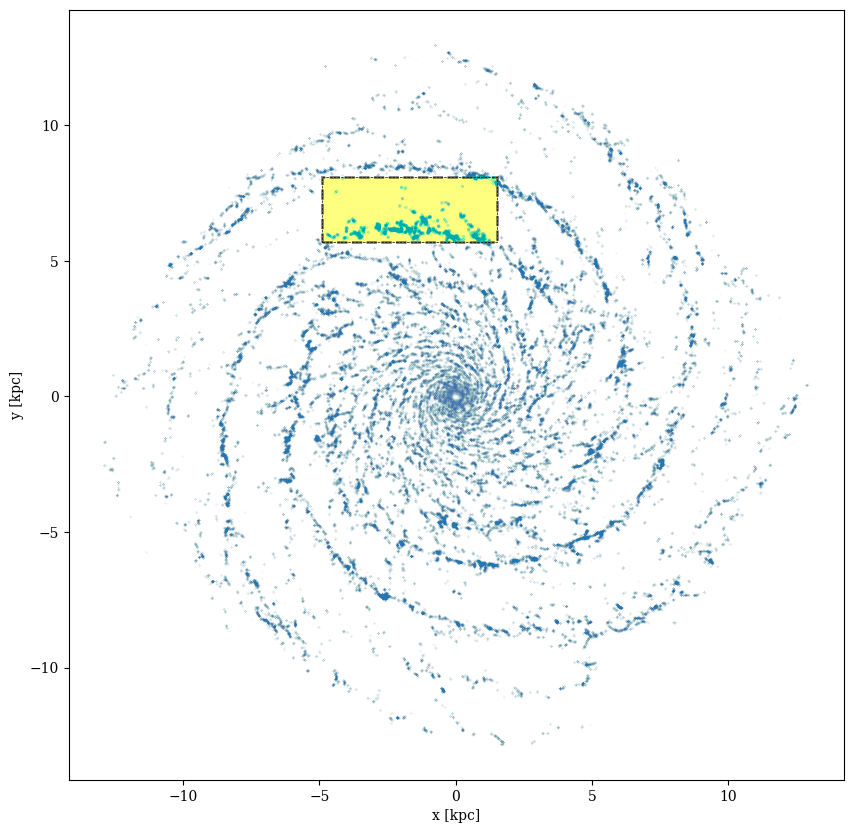

In [38]:
#Assigning new plots and creating new area
plt.figure(8, (10, 10))
plt.scatter(xa_cut, ya_cut, s = 0.01, alpha = 0.065)
plt.xlabel('x [kpc]'); plt.ylabel('y [kpc]')

# List of colors
color_cycle = ['green', 'cyan', 'red', 'purple', 'blue', 'chocolate']

#Inserting linear equation
def get_line_eq(x0, x1, y0, y1):
    return y0 - y1, x1 - x0, x0 * y1 - x1 * y0

#Extracting spurs
def extract_spur(spur_extracted, color_index = 0):

    plt.plot(spur_extracted[:, 0], spur_extracted[:, 1], 'k--', lw = 0.5)
    equation = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(spur_extracted[:-1], spur_extracted[1:])]
    filter = np.all([a*xa_cut + b*ya_cut + c > 0 for a, b, c in equation], axis = 0)

    xa_cut_for_lv = xa_cut[filter]
    ya_cut_for_lv = ya_cut[filter]

    vxa_cut_for_lv = vxa_cut[filter]
    vya_cut_for_lv = vya_cut[filter]

    colors = color_cycle[color_index % len(color_cycle)] #color sequences

    plt.scatter(xa_cut_for_lv, ya_cut_for_lv, s = .01, c = colors, alpha = 0.08, lw = 2)
    plt.fill(spur_extracted[:, 0], spur_extracted[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)

    return xa_cut_for_lv, ya_cut_for_lv, vxa_cut_for_lv, vya_cut_for_lv


#xa_cut_for_lv01, ya_cut_for_lv01, vxa_cut_for_lv01, vya_cut_for_lv01 = extract_spur(spur_extracted=first_region, color_index=0)
xa_cut_for_lv02, ya_cut_for_lv02, vxa_cut_for_lv02, vya_cut_for_lv02 = extract_spur(spur_extracted=second_region, color_index=1)




Text(0, 0.5, 'vya [km/s]')

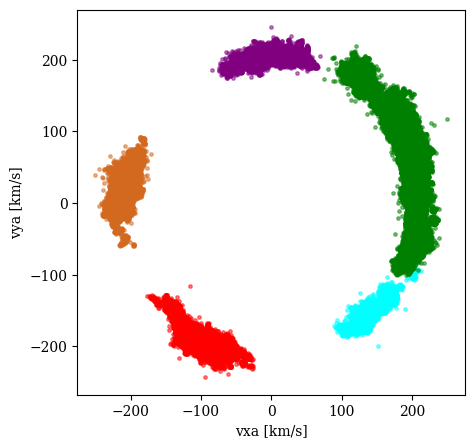

In [14]:
plt.figure(0, (5,5))
plt.scatter(vxa_cut_for_lv0, vya_cut_for_lv0, s = 6, c = 'red', alpha = 0.5)
plt.scatter(vxa_cut_for_lv1, vya_cut_for_lv1, s = 6, c = 'purple',alpha = 0.5)
plt.scatter(vxa_cut_for_lv2, vya_cut_for_lv2, s = 6, c = 'cyan', alpha = 0.5)
plt.scatter(vxa_cut_for_lv3, vya_cut_for_lv3, s = 6, c = 'chocolate', alpha = 0.5)
plt.scatter(vxa_cut_for_lv4, vya_cut_for_lv4, s = 6, c = 'green', alpha = 0.5)
plt.xlabel("vxa [km/s]"); plt.ylabel("vya [km/s]")

# $  Chapter-4: The\;Making\;of\;LV   $

In [15]:
# perform some coordinate transforms from Cartessian -> cylindrical polars

def make_cor(x, y, vx, vy):
    theta       = np.arctan2(y , x)
    Theta_p     = np.copy(theta)
    Theta_p[theta<0.] = theta[theta<0.]+2. * np.pi   #shifts things
    rcirc       = np.sqrt(x*x + y*y)
    vcirc       = np.sqrt(vx*vx + vy*vy)    #RC of the data points.
    
    #Angular frequency:
    Omega       = vcirc/rcirc
    
    #Radial/azimuthal component of velocity:
    vr          = (vx*np.cos(Theta_p) + vy*np.sin(Theta_p))
    vp          = -(vy*np.cos(Theta_p) - vx*np.sin(Theta_p))


cut_coordinate = make_cor(xa_cut, ya_cut, vxa_cut, vya_cut)
#first_coordinate = make_cor(xa_cut_for_lv01, ya_cut_for_lv01, vxa_cut_for_lv01, vya_cut_for_lv01)
second_coordinate = make_cor(xa_cut_for_lv02, ya_cut_for_lv02, vxa_cut_for_lv02, vya_cut_for_lv02)

In [16]:
# Pick some coordinates for the Sun (distance from centre and circular velocity)
from pynbody import units
Ro   = 4.0 * units.kpc
Vo   = 220.*units.km/units.s #could be smarter here and pick from disc average at Ro...
lobs = 0.
print(Ro)
print(Vo)

4.00e+00 kpc
2.20e+02 km s**-1


In [17]:
#change coordinate system to one centered on the Sun rather than centre of the galaxy:
yRo  = Ro * np.sin((lobs+90.)*np.pi/180.)
xRo  = Ro * np.cos((lobs+90.)*np.pi/180.)

In [18]:
def initiate_lv(x, y, vx, vy, rhos, xRo, yRo, Vo):
    alphav = np.arctan2(vy,vx)
    d = np.sqrt((x-xRo)**2 + (y-yRo)**2)
    l = np.arctan2((y-yRo),(x-xRo))
    #b = np.arctan2(z,np.sqrt((y-Ro)**2+(x-xRo)**2))  #ignoring lattitude for now...
    l[l>=90*np.pi/180.0]=l[l>=90*np.pi/180.0]-2.0*np.pi
    l[l<90*np.pi/180.0] =l[l<90*np.pi/180.0] +0.5*np.pi

    vLOS  = (np.sqrt(vx**2+vy**2) * np.sin( -alphav + l )  -  Vo*np.sin(l)  )
    I_approx = rhos / (d**2) #approx emission scaling with radius
    return alphav, l, vLOS

alphav0, l0, vLOS0 = original_initiation = initiate_lv(xa_cut, ya_cut, vxa_cut, vya_cut, rhos_cut, xRo, yRo, Vo)
#alphav1, l1, vLOS1 = first_initiation = initiate_lv(xa_cut_for_lv01, ya_cut_for_lv01, vxa_cut_for_lv01, vya_cut_for_lv01, rhos_cut, xRo, yRo, Vo)
alphav2, l2, vLOS2 = second_initiation = initiate_lv(xa_cut_for_lv02, ya_cut_for_lv02, vxa_cut_for_lv02, vya_cut_for_lv02, rhos_cut, xRo, yRo, Vo)


# $  Chapter-5:Longitudinal\;Velocity\;Map,$
# $ not\;Louis\;Vuitton $

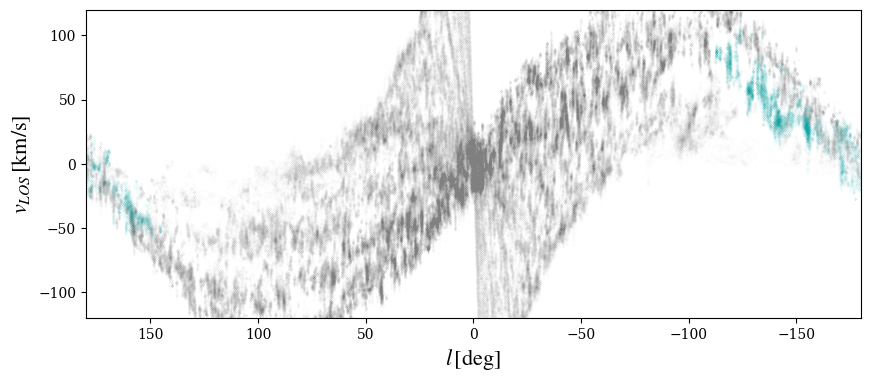

In [19]:
def make_lv(l, vLOS, first_plot = False, color_index = 0):
    plt.figure(9, (10, 4))
    
    if first_plot:
        colors = 'grey'
    else:
        colors = color_cycle[color_index % len(color_cycle)]
        
    plt.scatter(l*180./np.pi, vLOS, s = 0.004, c = colors, alpha = 0.14)
    plt.xlim(-180,180)
    plt.gca().invert_xaxis()
    plt.ylim(-120,120)

    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.gca().set_aspect('auto', adjustable='box')
    
    plt.xlabel('$l \,\\rm{[deg]}$',fontsize=16)  
    plt.ylabel('$v_{LOS} \,\\rm{[km/s]}$',fontsize=16) 
    #plt.savefig('1LVpin_'+ptype2+'.png',dpi=1000)

    

original_lv = make_lv(l0, vLOS0, first_plot = True)


#first_lv = make_lv(l1, vLOS1, color_index = 0)
second_lv = make_lv(l2, vLOS2, color_index = 1)

plt.show()

Text(0, 0.5, '$v_{LOS} \\,\\rm{[km/s]}$')

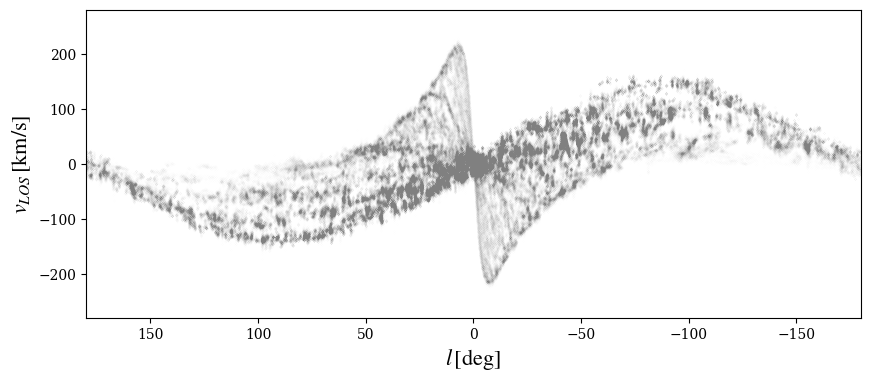

In [20]:
#bin up particles into LV space
#minCount0 = 10 #minium number of particles to plot in bins
#minCount1 = 10
plt.figure(9,(10,4))
#plt.hist2d(l0*180./np.pi,vLOS0,bins=500,cmap='bone_r',norm=matplotlib.colors.LogNorm(minCount0,None))
#plt.hist2d(l1*180./np.pi,vLOS1,bins=500,cmap='red',norm=matplotlib.colors.LogNorm(minCount1,None))
plt.scatter(l0*180./np.pi, vLOS0, s = 0.001, c = 'gray', alpha = 0.2)


plt.xlim(-180,180)
plt.gca().invert_xaxis()
plt.ylim(-280,280)

plt.xlabel('$l \,\\rm{[deg]}$',fontsize=16)  
plt.ylabel('$v_{LOS} \,\\rm{[km/s]}$',fontsize=16) 
#plt.savefig('LVbin_'+ptype2+'.png',dpi=1000)

# $  Chapter-6:What\;if...!   $

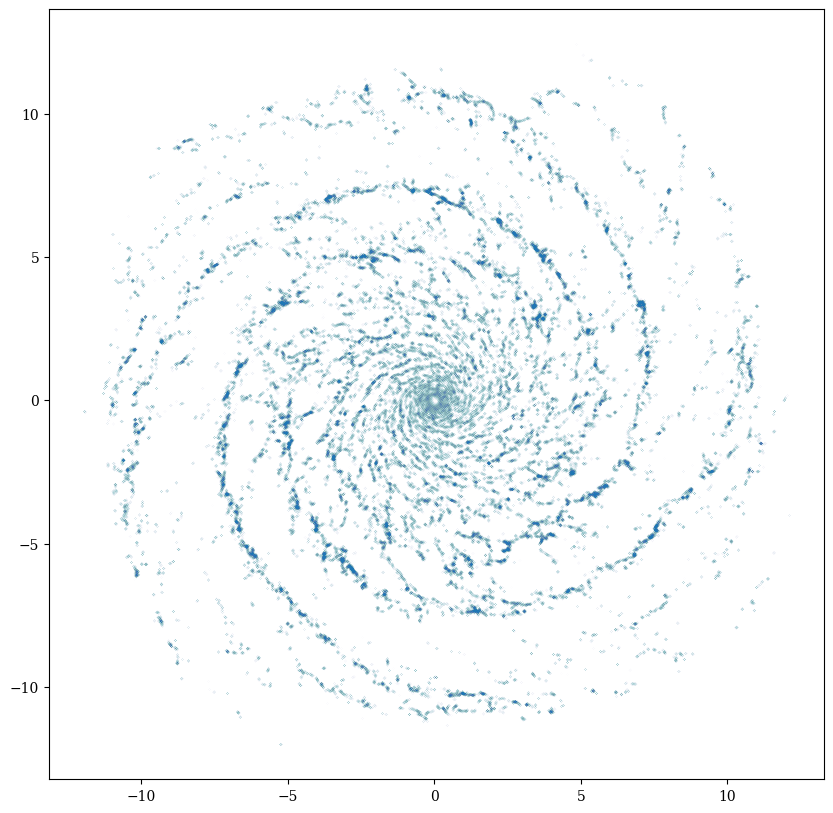

In [26]:
theta0 = np.arctan2(ya_cut, xa_cut)
# It needs rotation angle added to it

# Theta to degree
theta0_deg = np.degrees(theta0)

# Input rotation angle in degrees
rotation_angle_deg = 135

# Convert rotation angle to radians
rotation_angle_rad = np.radians(rotation_angle_deg)

# Rotation matrix
cos_theta = np.cos(rotation_angle_rad)
sin_theta = np.sin(rotation_angle_rad)
rotation_matrix = np.array([[cos_theta, -sin_theta],
                            [sin_theta, cos_theta]])

rotated_points = np.dot(rotation_matrix, np.array([xa_cut, ya_cut]))
rotated_velocities = np.dot(rotation_matrix, np.array([vxa_cut, vya_cut]))

#Setting up new xa, ya, vxa, and vya values 
new_xa = rotated_points[0]
new_ya = rotated_points[1]

new_vxa = rotated_velocities[0]
new_vya = rotated_velocities[1]

plt.figure(8, (10, 10))
plt.scatter(new_xa, new_ya, s = 0.01, alpha = 0.05)

In [42]:
#point list for rotating galaxy
def make_points(point_sets):
    print(point_sets)
    print(point_sets.values())
    for points in point_sets.values():
        t1 = points[0]
    print(t1)
    pnts = [points[:+2], points[+2:+4], points[+4:+6], points[+6:+8]]
    print(pnts)

    pnts = pnts + [pnts[0]]
    pnts = np.array(pnts)
    return pnts
first_region = make_points(point_sets = point_list[0])
second_region = make_points(point_sets = point_list[1])
...
print(first_region)
print(second_region)

{'first_region': [-4.9, 2.7, 1.5, 2.7, 1.5, 5.7, -4.9, 5.7]}
dict_values([[-4.9, 2.7, 1.5, 2.7, 1.5, 5.7, -4.9, 5.7]])
-4.9
[[-4.9, 2.7], [1.5, 2.7], [1.5, 5.7], [-4.9, 5.7]]
{'second_region': [-4.9, 5.7, 1.5, 5.7, 1.5, 8.1, -4.9, 8.1]}
dict_values([[-4.9, 5.7, 1.5, 5.7, 1.5, 8.1, -4.9, 8.1]])
-4.9
[[-4.9, 5.7], [1.5, 5.7], [1.5, 8.1], [-4.9, 8.1]]
[[-4.9  2.7]
 [ 1.5  2.7]
 [ 1.5  5.7]
 [-4.9  5.7]
 [-4.9  2.7]]
[[-4.9  5.7]
 [ 1.5  5.7]
 [ 1.5  8.1]
 [-4.9  8.1]
 [-4.9  5.7]]


In [44]:
print(first_region[:,1])

[2.7 2.7 5.7 5.7 2.7]


[[-4.242640687119285, 4.440892098500626e-16], [-5.65685424949238, 1.4142135623730954], [-7.0710678118654755, 4.440892098500626e-16], [-5.656854249492381, -1.4142135623730945]]


<Figure size 1000x1000 with 0 Axes>

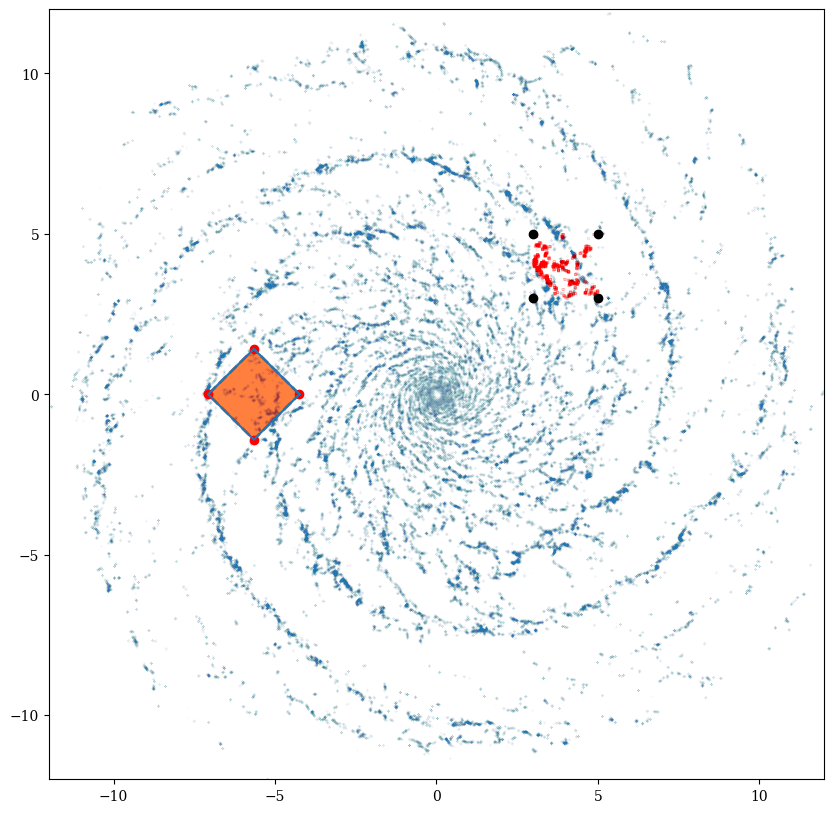

In [22]:
# Selecting regions for rotation
"""xa_rotate = [xa0, xa1, xa2, xa3] = [3.5, 6.0, 7.0, -3.5]
ya_rotate = [ya0, ya1, ya2, ya3] = [-3.5, -3.5, -1.5, -1.5]"""

xa_rotate = [xa0, xa1, xa2, xa3] = [3, 5, 5, 3]
ya_rotate = [ya0, ya1, ya2, ya3] = [3, 3, 5, 5]

pnts00 = [[xa0, ya0], [xa1, ya1], [xa2, ya2], [xa3, ya3]]

rotated_regions = np.dot(rotation_matrix, np.array([xa_rotate, ya_rotate]))

new_rotated_xa_region = rotated_regions[0]
new_rotated_ya_region = rotated_regions[1]

plt.figure(12, (10, 10))
plt.plot(xa_rotate, ya_rotate,'ko')
plt.plot(new_rotated_xa_region, new_rotated_ya_region, 'ro')
plt.xlim(-12, 12); plt.ylim(-12, 12)






pnts00 = pnts00 + [pnts00[0]] # repeat first point to create a closed polygon
pnts00 = np.array(pnts00) # numpy arrays are easier to separate x and y coordinates

#plt.plot(pnts00[:, 0], pnts00[:, 1])

new_pnts00 = [[new_rotated_xa_region[0], new_rotated_ya_region[0]], [new_rotated_xa_region[1], new_rotated_ya_region[1]], [new_rotated_xa_region[2], new_rotated_ya_region[2]], [new_rotated_xa_region[3], new_rotated_ya_region[3]]]
new_pnts00 = new_pnts00 + [new_pnts00[0]]
new_pnts00 = np.array(new_pnts00)

plt.plot(new_pnts00[:, 0], new_pnts00[:, 1])


#Inserting linear equation
def get_line_eq(x0, x1, y0, y1):
    return y0 - y1, x1 - x0, x0 * y1 - x1 * y0

pnts00 = [[new_rotated_xa_region[0], new_rotated_ya_region[0]], [new_rotated_xa_region[1], new_rotated_ya_region[1]], [new_rotated_xa_region[2], new_rotated_ya_region[2]], [new_rotated_xa_region[3], new_rotated_ya_region[3]]]
print(pnts00)
pnts00 = pnts00 + [pnts00[0]] # repeat first point to create a closed polygon
pnts00 = np.array(pnts00) # numpy arrays are easier to separate x and y coordinates

#plt.plot(pnts00[:, 0], pnts00[:, 1], 'k--', lw=0.5)
equations00 = [get_line_eq(x0, x1, y0, y1) for (x0, y0), (x1, y1) in zip(pnts00[:-1], pnts00[1:])]
filter00 = np.all([a*rotated_xa + b*rotated_ya + c > 0 for a, b, c in equations00], axis = 0)

xa_cut_for_lv00 = xa_cut[filter00]
ya_cut_for_lv00 = ya_cut[filter00]


plt.scatter(rotated_xa, rotated_ya, s = 0.01, alpha = 0.065)
plt.scatter(xa_cut_for_lv00, ya_cut_for_lv00, s = .01, color = 'red', alpha = 0.08, lw = 2)
plt.scatter(xa_cut_for_lv00, ya_cut_for_lv00, s = .01, color = 'red', alpha = 0.08, lw = 2)
plt.fill(pnts00[:, 0], pnts00[:, 1], fc='yellow', alpha=0.5, ec='k', ls='--', lw=2, zorder=0)

#plt.gca().add_patch(Polygon(rotated_regions, 'k--', lw=0.5))
plt.gca().add_patch(Polygon(pnts00, color='red', alpha=0.5))